[Table of Contents](./table_of_contents.ipynb)

#  g-h 滤波

In [2]:
from __future__ import division, print_function
%matplotlib inline

In [4]:
#format the book
import book_format
book_format.set_style()

## 思想实验

想象一下我们生活在一个没有称（用于测量体重的设备）的世界。 一天一个同事跑过来找到你，宣称她发明了一个叫做称的设备。 经过她的讲解之后，你迫不及待站了上去，**172 磅**。你很激动，人生中第一次你知道了自己的体重。更重要的是你看到了商机，可以通过卖这个玩意儿实现财富自由了！

另一个同事听到了骚动声跑过来。你解释了一下这个叫称的玩意儿，然后站上去，骄傲的公布 **161 磅**。这时你犹豫了，困惑了，蒙了。

"刚才还是 **172 磅**", 你开始向你的同事抱怨。

"我又没说我的称很准"

传感器是有误差的。 这正是大量滤波研究的初衷所在，也是本书要解决的问题。我将展示半个多世纪来我们的研究工作者是怎么解决这个问题的。在我们展开对应的数学知识之前，我们继续我们称的故事，希望借此能帮助我们能直观理解所谓的滤波。

**另一个称**

有办法改进我们的称重结果么？很明显，换个好点儿的称是个好主意。不幸的是你同事说她就做了10个称，并且所有的称质量大差不离。于是她又拿来一个称，现在你有两个称。于是你称了两次体重，称 (A) 显示 160 磅, 称 (B) 显示 170 磅。 那你究竟体重几何呢？

好吧，现在怎么办?

* 信任称 A, 将 160磅作为我们的体重估计值
* 信任称 B, 将 170磅作为我们的体重估计值
* 选一个比160小的数
* 选一个比170大的数
* 选一个介于160和170之间的数

前两个方案貌似可信，可我们选择其中一个的理由是什么呢，凭什么厚此薄彼呢？接下来的两个简直不可理喻了，称是不准，但我们此刻没有任何根据选择一个“法外之数”。现在只剩下最后一个选择，这也是唯一合理的选择。如果两个称都不准，结果要么高点儿，要么低儿，那么真相往往就在两者之间。 

在数学上有一个概念叫 [*期望值*](https://en.wikipedia.org/wiki/Expected_value), 稍后讲解。
> 在概率论和统计学中，数学期望(mean)（或均值，亦简称期望）是试验中每次可能结果的概率乘以其结果的总和，是最基本的数学特征之一。它反映随机变量平均取值的大小。
需要注意的是，期望值并不一定等同于常识中的“期望”——“期望值”也许与每一个结果都不相等。期望值是该变量输出值的平均数。期望值并不一定包含于变量的输出值集合里。
大数定律规定，随着重复次数接近无穷大，数值的算术平均值几乎肯定地收敛于期望值. (引用自 百度百科)

 想象一下，如果我们称近百万次呢？有时，两个称都称低了，有时都称高了，但大多数时候会是一个高一个低。当结果一高一低时，我们当然要选一个介于两个读数之间的值。可如果是都称高了或者都称低了呢？我们是否还是要选一个介于两者之间的数呢？例如，我们的实际重量是180磅，160磅将是一个很大的误差。可我们选择一个介于160与170之间的数，我们的这个估计至少比160好。当两个称都称高的时候也一样。稍后，我们将用更高级的方法处理这个问题，现在我们将称A和称B的均值作为我们的最优估计，

$$\frac{160+170}{2} = 165$$

我们通过图来更直观的看看这个问题，假设两个称的误差都是8磅。测量结果在160与170之间，所以体重也就介于两个数值之间。 

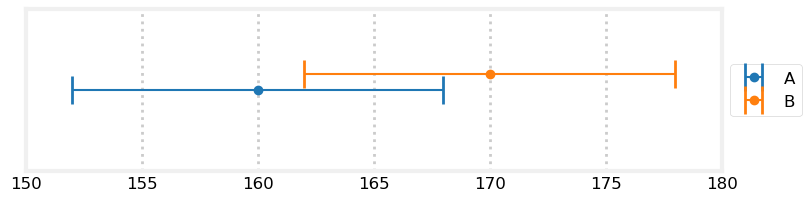

In [5]:
import kf_book.book_plots as book_plots
from kf_book.book_plots import plot_errorbars
plot_errorbars([(160, 8, 'A'), (170, 8, 'B')], xlims=(150, 180))


所以165磅是个合理的估计，可是我们有更多的信息可以应用。可能的体重结果理论上只能出现在两条线的交集内。例如，161磅是一个不可能的估计，因为称B的读数为170，称最多有8的误差，那么真实的体重是不会小于162的。同样，考虑到称A的结果和误差，169也不是一个可能的估计。所以，上边的例子中体重的可能区间被缩小到162-168.

然后呢？这个信息并没有让我们的估计结果有什么提高，继续玩我们的思想实验。如果称A比称B质量好呢？假设A的最大误差是3，B的最大误差是9.在此种情况下，似乎我们有更多的理由选则A作为我们的估计，毕竟A的精度更高。B能提高我们的精度么？

答案是肯定的。假设我们的测量结果依然是A=160 B=170.

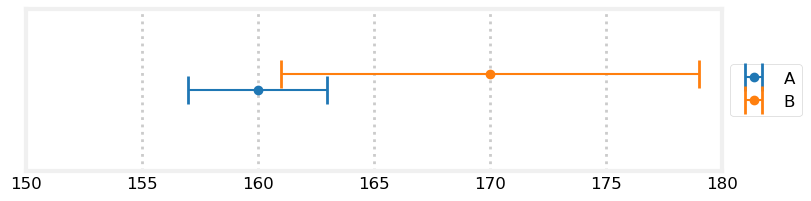

In [6]:
plot_errorbars([(160, 3, 'A'), (170, 9, 'B')], xlims=(150, 180))

真实的体重只可能存在于两条线的重叠部分。可以看到，这个重叠部分的范围要比只使用A的情况要小。更重要的是这个结果不包含160和165。如果我们因为A的精度高而只用A的话，我们给出的估计将会是160.如果我们按照之前的方法进行平均那么我们给出的估计是165.考虑到精度信息的话，这两个值都是不可能的！所以，考虑到精度信息的话，我们的估计值的范围应在161-163之间。

继续我们的思想实验。假设A的最大误差是1.换句话说，如果我们的体重是170，那么A称得的结果只能是169，170，171. B的最大误差依然是9.现在我们用两个称称一下体重，A=160,B=170. 那我们的体重估计是多少呢？且看下图。

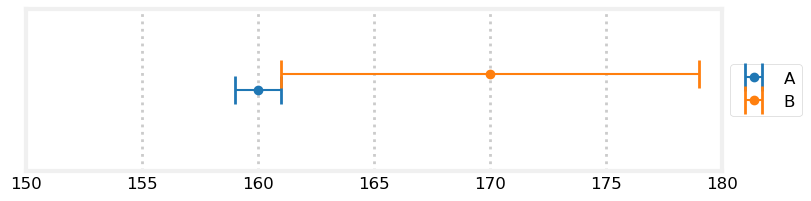

In [7]:
plot_errorbars([(160, 1, 'A'), (170, 9, 'B')], xlims=(150, 180))

我们可以看到，唯一可能的结果是161.多么令人欣喜。用两个相对不准确的传感器我们竟然得到了真值！

**两个传感器总比一个好，即便一个比另一个精度差也是如此。** 在本书中我会反复强调这个观点。我们不丢弃让你和数据，哪怕精度再差也一样。我们会开发相应的算法来融合所有来源的数据，从而得到最优估计。

且慢,我们扯远了。没有人会愿意买一大堆称，并且同事已经说了，所有的称质量都半斤八两——精度是一样的。

如果我只买一个称，然后称很多次呢？上边我们说了，有两个同等精度的称时，我们会将结果平均。那如果我用同一个称称10,000次呢？不难证明，对大量测量数据的平均会非常接近真值，下面我们做个仿真实验。

In [8]:
import numpy as np
measurements = np.random.uniform(160, 170, size=10000)
mean = measurements.mean()
print('量测均值为 {:.4f}'.format(mean))

量测均值为 165.0145


上述仿真输出的结果取决于随机数生成器，但无论如何这个结果会很接近165.

上述代码做了一个假设。对于165的真实重量，测量结果是160和165的可能是一样的。而实际情况通常不是如此。实际传感器的输出在真值附近的可能性要大，离真值越远，可能性就越小。在后边高斯分布的章节会讲这个问题。现在，使用函数`numpy.random.normal()`生成真值为165的高斯分布，这个函数生成的随机数更加像一个真实传感器的输出。

In [9]:
mean = np.random.normal(165, 5, size=10000).mean()
print('量测均值为 {:.4f}'.format(mean))

量测均值为 165.0316


结果依然接近165.

好吧，我们找到了一个称重问题的解决方案！等等～。谁会有这个耐心称体重的时候上上下下上万次呢，恐怕十次都难。

继续我们的思想实验。如果是每天称一次呢？结果是170，161，169.这说明什么？体重在涨，在减，还是这些只是称的误差的影响，实际上你的体重一直没变。

鬼知道。从170到169，貌似少了1磅。但如果称的最大误差是10，那么说少的这1磅是称的误差引起的，也完全说的通。或许第一天的真实体重是165，第三天的真实体重是172，实际是在增肥，这也有可能啊。所以，体重称貌似说明我们在减肥，说不定我们体重正在嗖嗖上涨！看下边的图更加直观。

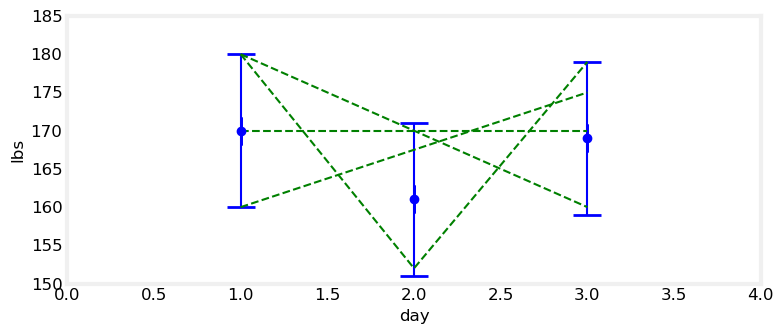

In [10]:
import kf_book.gh_internal as gh
gh.plot_hypothesis1()

看吧，绿线就是可能的体重走势。理论上，有无数种可能。放弃么？不是我性格！我们必须意识到我们讨论的是测量一个人的体重。**正常情况下**，人的体重不可能第一天180到了第三天突然变成160.也不可能一天之内掉肉30磅，下一天又涨回来了。

我们对量测结果的解读，应该符合被测物体本身的固有特性。例如，我们测量的是一块石头每天的重量，那么测量结果的变化理论上都是噪声引起的。如果我们有一个蓄水池（接的雨水）供应我们的家庭用水，我们对它的水位进行测量，那这种测量结果的变化更多的反应的是实际水位的变化。

假设我又换了个称，每天称一下，结果是： 169, 170, 169, 171, 170, 171, 169, 170, 169, 170.直觉是？或许你每天都涨了1磅，可是在噪声的影响下，看起来你的体重一直保持不变。或许，你每天都减了1磅，也有可能得到这样的结果。真的会么？仍十次硬币，都是正面朝上的概率多大？微乎其微。所以通过这组数据比较合理的推断是，你的体重基本保持不变。直观结果看下图，绿色虚线为趋势线。真实体重变化可能与趋势线不同，但这至少是一个合理的解释。

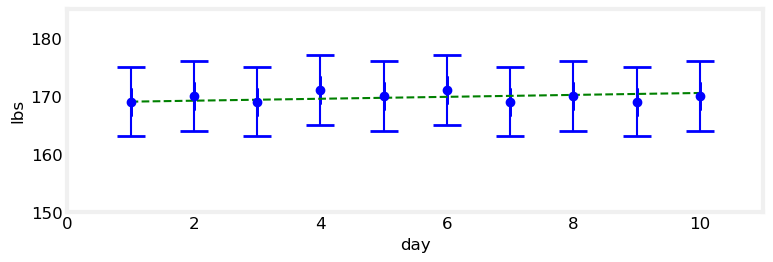

In [11]:
gh.plot_hypothesis2()

继续我们的思想实验，如果读数是 158.0, 164.2, 160.3, 159.9, 162.1, 164.6, 169.6, 167.4, 166.4, 171.0? 先看图，再思考几个问题。

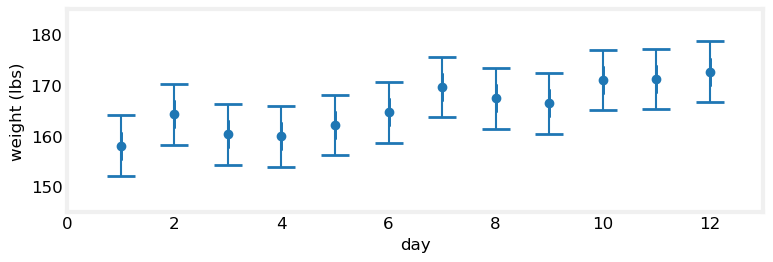

In [12]:
gh.plot_hypothesis3()

我体重下降了，这些波动都是测量噪声引起的？不像。我体重没变？也不像。曲线变化的趋势是上升的，虽然不均匀，但肯定是上升的。虽然我们没法百分百确定，但是从曲线看来我在明显的增重。我们通过画图来验证这个假设。看图要比看表简单多了。

我们来做两个假设。首先，假设我体重没变。那么我将所有数据平均来估计我的真实体重，看下图。


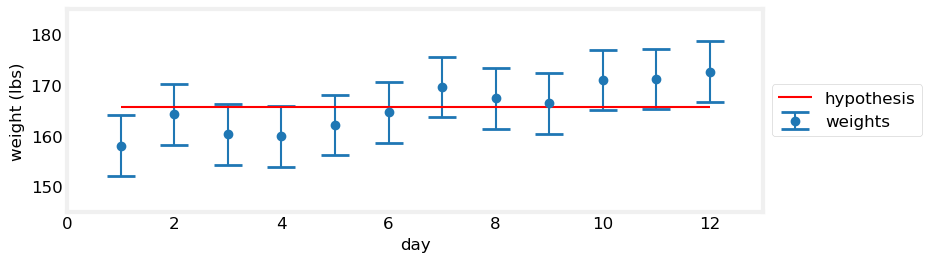

In [13]:
gh.plot_hypothesis4()

完全没有说服力，我们设置无法画一条线，使其穿过所有的蓝色区间。

现在假设我在增重，增了多少？不知道，但是Numpy可以。NumPy的`polyfit()`可以根据最小二乘拟合画一条红线。我们暂且不要过度关注于这个函数本身，用就是了。

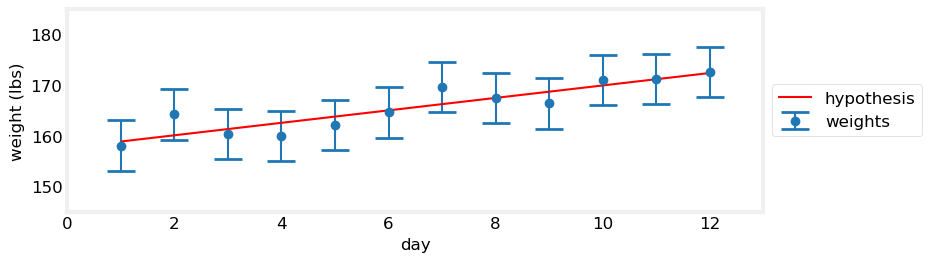

In [14]:
gh.plot_hypothesis5()

这个看起来顺眼多了。可以看到这个假设离每个观测都很近，而在上一个假设中，有的地方已经跑出了观测的误差范围。所以，我在增重的可能比保持不变的可能要大很多。然而，我真的涨了13磅么？鬼知道。这看起来很难回到。

“不可能知道么？” 同事问道。

来点儿疯狂的点子。假设我每天涨1磅。别问我怎么知道的，假设这个假设大致准确。或许我每天摄入足够多的卡路里，或许我有其他增重方式，总之我大约每天涨1磅。这是一个思想实验，不必拘泥小节。那这个假设有什么用呢？

第一个测量值是158.我们就把这个值作为第一次的估计值（第一次也没有其他值可用）。如果我们今天重158，明天呢？我们既然已经知道每天涨1磅，明显我们预计明天将会是159，如下图：

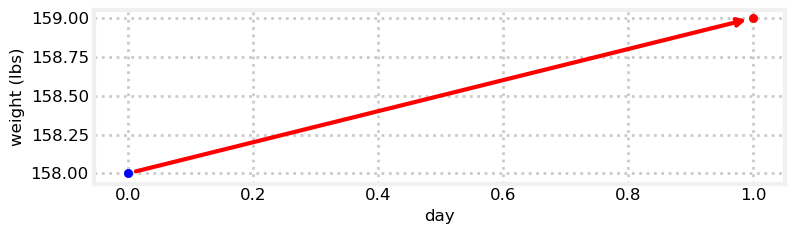

In [15]:
gh.plot_estimate_chart_1()

但是，这么假设有什么好处呢？当然有好处，现在我们可以预计以后10天的体重了。那么问题又来了，现在要称干什么？别急，继续实验，我走上体重称，164.2磅。

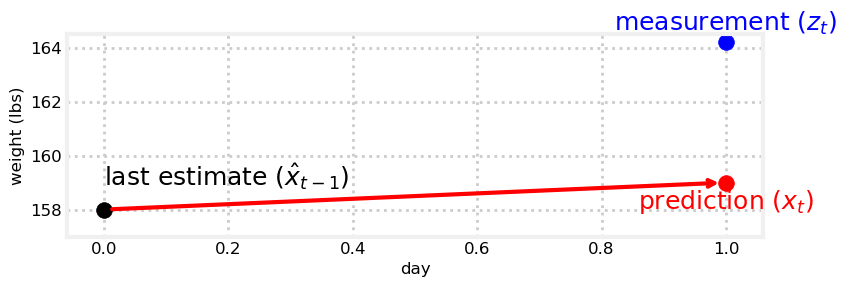

In [16]:
gh.plot_estimate_chart_2()

问题来了，我们的预测与量测矛盾。意料之中，不是么？如果两者一致的话，我们的滤波器就没用了。而且如果一致的话，我们的体重可以靠猜，那还买称干什么呢?

> **注意了，前方高能。本书的精华就在下一段!**

何去何从？如果只用量测值，那么预测就没什么用了。如果把预测作为估计值，那么量测值的意义又在哪？要走出困境我们需要的是一种**预测和量测的数据融合方法**（加粗的就是精华所在了）

融合两者 - 似乎又回到了两个称的问题。根据之前的经验我们只需在预测值和量测值之间选一个数即可。那么，估计165或者157都是不合适的，我们的估计值应介于159(预测值)和164.2(量测值)之间。

再罗嗦一下，我们应该有这个意识，当我们进行数据融合时，我们的估计值应介于两个数值加。这与这两个数的来源无关。本问的开始我们用的是两个量测值，现在我们用一个量测值一个预测值。其中蕴含的数学原理是一样的。我们**永不**抛弃数据。我是认真的。很多商业软件做数据剔除。这很不好！虽然我们预测数据不准，但依然有可取之处。

现在你可以思考一下。这里我做的只不过把一个不准的称换成了基于人体实际状况的预测。从数学上来讲，并不区分这个数据是称称出来的还是一个预测值。这是两个都有噪声的数据，我们要做的就是融合他们。本书中还会设计一些很复杂的滤波算法，但无论如何，数学上讲，数据从哪里来都一样，算法只关心数据的值和精度两个信息。

我们的估计值取量测和预计的均值么？或许吧，可通常情况下我们的预计或多或少比称好点儿，或许这取决于称。记得之前我们一个好称A和一个次称B的处理么？我们让估计离A近一点。看图吧。

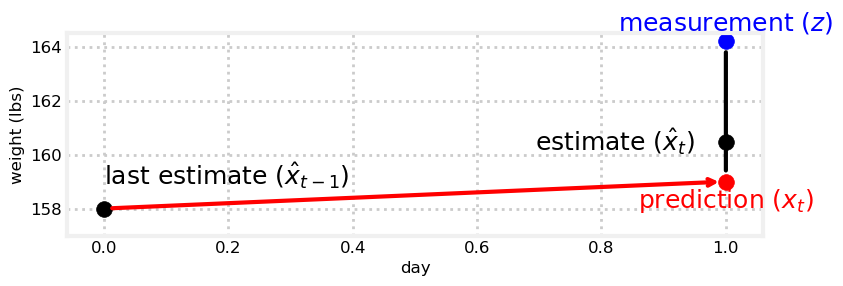

In [17]:
gh.plot_estimate_chart_3()

我们先随便选个数: $\frac{4}{10}$.预测和量测六四分。换句话说，我们认为自己预测的比称准，准多少呢？准两分。于是，我们按照下边的公式做估计，

$$\mathtt{estimate} = \mathtt{prediction} + \frac{4}{10}(\mathtt{measurement} - \mathtt{prediction})$$

量测和预测的差叫做*残差*，即上图中的垂直黑线。这个值很重要，以后会用到。这个值也表征了量测和滤波输出的差异，残差越小往往说明滤波性能越好。

我们用之前思想实验生成的那组数做个实验。

我已经生成了符合假设模型的数据，换句话说这些数据的真值从160开始，每天加1，在生成的数值上加点儿噪声就可以了。也就是说，第一天的真值是160，第二天的真值为161，依此类推。

我们预计值的初值怎么选呢？滤波器的初始化，言之尚早，我们先用160吧。

In [18]:
from kf_book.book_plots import figsize
import matplotlib.pyplot as plt

weights = [158.0, 164.2, 160.3, 159.9, 162.1, 164.6, 
           169.6, 167.4, 166.4, 171.0, 171.2, 172.6]

time_step = 1.0  # day
scale_factor = 4.0/10

def predict_using_gain_guess(estimated_weight, gain_rate, do_print=False):     
    # storage for the filtered results
    estimates, predictions = [estimated_weight], []

    # most filter literature uses 'z' for measurements
    for z in weights: 
        # predict new position
        predicted_weight = estimated_weight + gain_rate * time_step

        # update filter 
        estimated_weight = predicted_weight + scale_factor * (z - predicted_weight)

        # save and log
        estimates.append(estimated_weight)
        predictions.append(predicted_weight)
        if do_print:
            gh.print_results(estimates, predicted_weight, estimated_weight)

    return estimates, predictions

initial_estimate = 160.
estimates, predictions = predict_using_gain_guess(
    estimated_weight=initial_estimate, gain_rate=1, do_print=True)     

上次估计: 160.00, 预测: 161.00, 估计 159.80
上次估计: 159.80, 预测: 160.80, 估计 162.16
上次估计: 162.16, 预测: 163.16, 估计 162.02
上次估计: 162.02, 预测: 163.02, 估计 161.77
上次估计: 161.77, 预测: 162.77, 估计 162.50
上次估计: 162.50, 预测: 163.50, 估计 163.94
上次估计: 163.94, 预测: 164.94, 估计 166.80
上次估计: 166.80, 预测: 167.80, 估计 167.64
上次估计: 167.64, 预测: 168.64, 估计 167.75
上次估计: 167.75, 预测: 168.75, 估计 169.65
上次估计: 169.65, 预测: 170.65, 估计 170.87
上次估计: 170.87, 预测: 171.87, 估计 172.16


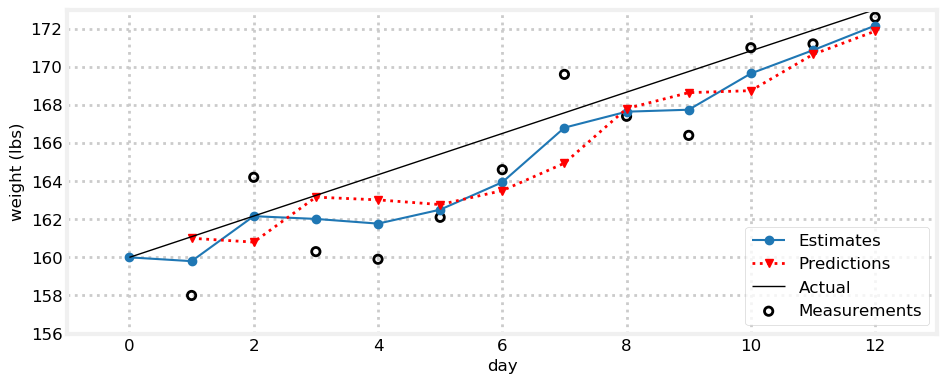

In [19]:
# plot results
book_plots.set_figsize(10)
gh.plot_gh_results(weights, estimates, predictions, [160, 173])

我们来看一下这个图。蓝线是估计值，第一天从160开始。红线是基于上一天估计值的预测值。所以第一天（天的计数从0开始）是160+1=161.第一天的估计值介于161和量测159.8之间。我们在程序中打印出了上次估计值，预测值和新的估计值。图中的黑线是真值。

你可以自己沿着坐标轴算一下，这样可以加深一下理解。

估计值的连接线并不是一条直线，但至少比量测值的曲线要接近直线，而且和真值表征的趋势线是接近的。更有意思的是，随着时间的增长滤波效果变得更好了。

你可能说，这不废话么。真相就是每天增1，我们的预计也是每天增1.那我们来看看我们的预计不靠谱的情况吧。现在假设我们每天减1磅。

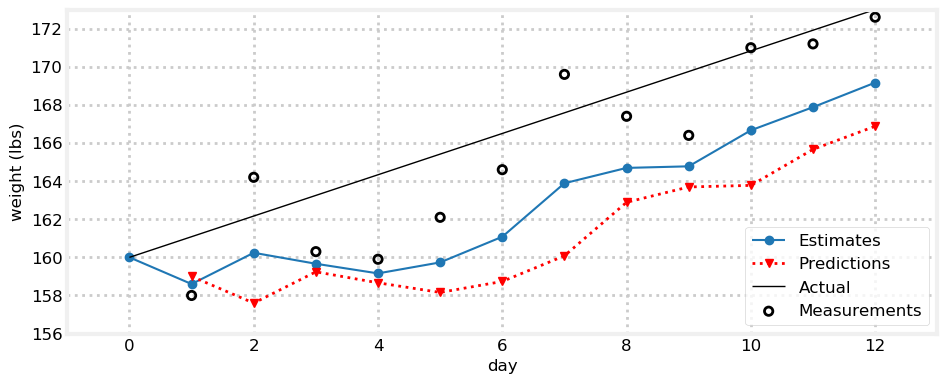

In [20]:
e, p = predict_using_gain_guess(initial_estimate, -1.)
gh.plot_gh_results(weights, e, p, [160, 173])

这个结果就不尽如人意了。我们的估计值很快就跑飞了。所以，一个准确的体重变化猜测对滤波性能很重要。即便我们的初值是准确的，变化率不对，滤波器也失败了。如果我不吃这么多了（实际体重增长不再是每天加1），这个滤波器很难去跟踪这个变化。注意了，滤波器一直试图跟踪！看图可知，即便我们告诉滤波器我每天减1磅，滤波器的结果还是爬升，只不过跟踪的不够快。

既然如此，我们何不使用量测和估计值计算体重增速，就别预计一个不变量了。因此第1天（请习惯天的计数从0开始）的体重是：

$$
(160 + 1) + \frac{4}{10}(158-161) = 159.8
$$

下一天我们的量测是164.2，说明什么呢？我们一天体重增加了4.4 (164.2-159.8=4.4) 而不是1.我们就直接用这个4.4？这么做也合情合理。毕竟量测来自体重，里面包含了有用信息。而我们的估计值虽然不完美，但至少比瞎猜一个1磅/天要强。换句话说，有噪声的数据总比瞎猜强。

对于上述观点好多人持保留意见，不过希望你能认可。两个带噪声的量测可以计算体重增速。当然不准确的量测会带来不准确的估计，这没什么，廖胜于无。你可以想象用误差是1磅的称去称牛的重量，结果显示牛每天涨10磅。对这头牛来说真实的增速可能是8也可能是12（这两个已经是误差极限了），但是我们可以确定它在涨，而且这个增速约等于10.这就是信息。有啥用呢？先别急，且听我慢慢道来。

回到我们的思想实验。我们要把体重增速调整为4.4么？之前我们预计的值是1，现在我们认为是4.4.矛盾产生了，我们需要一种融合。哇，这不就是我们之前讨论的问题么？我们使用相同的方法融合体重增速（当然目前为止我们只有一个方法-从两者的中间选一个数）。这次我用$\frac{1}{3}$作为融合比例。我们使用与体重融合相同的公式，不过得考虑时间，因为我们现在融合的是速的。

$$
\text{new gain} = \text{old gain} + \frac{1}{3}\frac{\text{measurement - predicted weight}}{1 \text{ day}}
$$

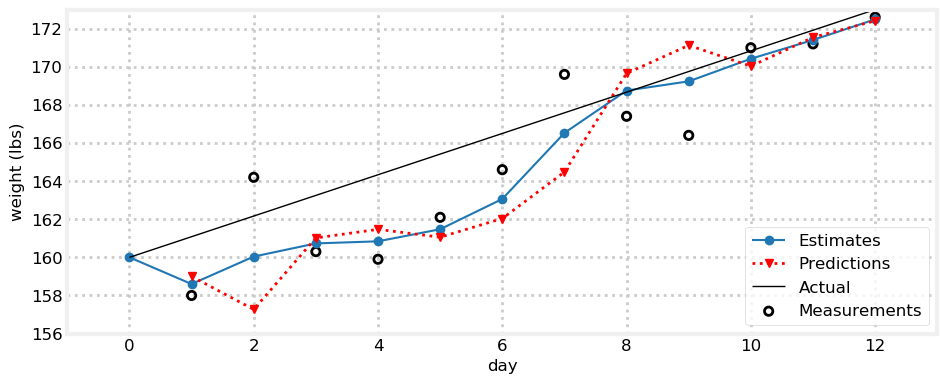

In [21]:
weight = 160.  # initial guess
gain_rate = -1.0  # initial guess

time_step = 1.
weight_scale = 4./10
gain_scale = 1./3
estimates = [weight]
predictions = []

for z in weights:
    # prediction step
    weight = weight + gain_rate*time_step
    gain_rate = gain_rate
    predictions.append(weight)
    
    # update step    
    residual = z - weight
    
    gain_rate = gain_rate + gain_scale   * (residual/time_step)
    weight    = weight    + weight_scale * residual
  
    estimates.append(weight)

gh.plot_gh_results(weights, estimates, predictions, [160, 173])

这个结果就不错了。因为错误的初始猜想（每天下降1磅）导致滤波器经过好几天才缓过神来，可是一旦滤波器回归到正确的轨道就可以比较高精度的跟踪真实体重。目前为止，我们对两个融合比例参数$\frac{4}{10}$ 和 $\frac{1}{3}$的选择很随意（实际上这是两个很糟糕的选择）。

声明一点，在滤波器的时间更新（prediction step）中，体重增速使用以下公式，
```python
gain_rate = gain_rate
``` 
当然了，对程序运行来说这行代码无任何意义。我把它写在这里只是想说，滤波器的时间更新中，我们应该对所有的状态量（体重和体重增量）进行一步更新。本例中我们的模型认为体重增量保持不变，当将滤波器的算法进行泛化时，这一假设当然会去除。

## g-h 滤波

[g-h 滤波](https://en.wikipedia.org/wiki/Alpha_beta_filter) 也叫 $\alpha$-$\beta$ 滤波. $g$ 和 $h$ 表示我们例子中使用的两个比例系数。$g$是用于量测的系数（我们例子中的体重），$h$是用于量测变化率的系数（我们例子中的体重变化率）。$\alpha$ 和 $\beta$是另一种叫法。 

g-h滤波是大量滤波器的基础，包括赫赫有名的卡尔曼滤波。换句话说，卡尔曼滤波是g-h滤波的一个特例(这个观点在本书中我会证明)。你很可能听过的最小二乘滤波也是。Benedict-Bordner滤波也是，当然这个滤波你很可能没听过。这些滤波器都有自己的$g$和$h$计算算法，可除此之外都一样。例如，Benedict-Bordner滤波使用常数$g$ $h$.卡尔曼滤波则对参数进行动态计算。

**重要的是说三遍**. 如果你不认可以下观点，那相信你很难读懂（认可）此书。如果你把以下几句话弄懂了，那么本书的剩余部分将会一马平川。

* 多个数据点总比一个好，所以不要剔除所谓的低精度数据
* 估计值要介于两个数据之间
* 我们的预测（时间更新）要基于上一步估计值和变化率
* 新的估计值介于预测值和量测值之间，融合比例取决于两者各自的精度

也可以用下边的图表示，predict step就是预测，也就是时间更新，输出的叫预测值，update step就是量测更新，输出的是新的估计.

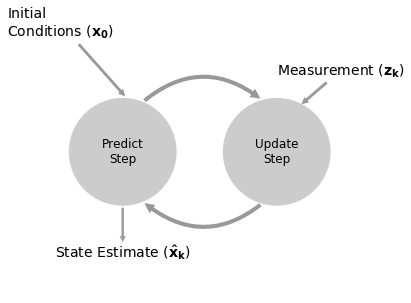

In [11]:
book_plots.predict_update_chart()

先来介绍一下滤波中的一些专业术语。**系统**——我们要估计的对象。对本章来说就是我们要称重的对象。有的教科书中也叫*plant*.此术语出自控制理论。https://en.wikipedia.org/wiki/Plant_(control_theory)

*状态* —— 是我们所关注的表征系统当前状态的一组值（所以滤波也叫状态估计）。本例中我们只关注体重的数字。如果我把一个100kg的砝码放在称上，状态值是100kg。状态的定义很重要，我们只选我们关注的。比如称的颜色与我们没啥关系，所以我们不把称的颜色作为状态。制造商的QA工程师或许会把颜色作为状态，以便进行生产过程的跟踪与控制。

*量测* —— 是系统的测量值。量测是有误差的，所以量测通常是与状态不相等的。

*状态估计*—— 就是我们用滤波器对系统状态的估计。例如，对于100kg的对象，我们的估计值可能是99.327. 状态估计通常简称估计。

换句话说，状态可以被理解为系统的真实值。这个值对我们来说是未知的。如果我站在称上得到的结果叫*量测*。状态对我们来说是*隐藏*的，你永远不能直接看到状态，你只能量测他（有时甚至不能直接进行量测）。

隐藏和观测对理解滤波的本质来说是很重要的。任何估计问题的本质就是通过量测来估计隐藏在背后的状态的过程。当你阅读滤波方面的文献的时候，状态、量测、估计、预测等都是不可规避的专业词汇，必须理解到位。

我们会用一个*过程模型*对系统进行系统建模。本章中的模型是什么呢？就是我们今天的体重等于昨天的体重加昨天的体重增量。过程模型不对量测进行建模。再举个汽车的例子。过程模型可以描述为“距离=速度乘以时间”。这个模型并不完美，首先车速是变化的，另外车轮可能在路上打滑等等吧。当我们说道“系统误差”或者叫“过程误差”的时候，就是我们建模的不精确性导致的误差。我们不可能知道这个误差的精确值；如果知道的话我们可以修改模型，然后只用模型就能计算真值了。有些书中管过程模型叫“系统模型”，意思是一样的。


预测过程又叫*递推*.预测过程使用系统模型计算出一个新的*状态估计*。因为系统误差的存在，这个估计是有缺陷的。假设我们是跟踪随时间变化的数据，那么我们认为我们对状态的未来值进行了一个预测，所以有的书里此过程又叫做*时间更新*。

图中的“update step”通常被称作*量测更新*。 一次递推和量测更新的过程被称作一个*历元*。

下边我们通过一个实际的场景来更好的理解这个算法。第一个场景我们跟踪一辆火车，由于轨道的存在，火车的轨迹被限定死了，不能像汽车那样随心所欲。另外，火车是个庞然大物。这样的结果是，火车的加速和减速过程也很慢。所以，当我确定某一时刻火车位于路标23km处，速度为18kph时，我可以非常自信的算出火车下一秒的位置。这就是模型的重要之处。假设我们传感器的测距精度是$\pm$ 250 米，火车的速度是18kph（5m/s）.那么下一秒火车的位置应该是23.005km。可是考虑到传感器精度，我们得到的量测很可能是22.755-23.255之间的任何值。所以，如果我们下一秒读到的数是23.4，那么我们知道这一定是一个很不靠谱的值。即使上一个时刻，火车司机拉了刹车，那么火车下一秒的位置也会接近23.005，因为一秒的时间火车速度减的实在有限。所以如果我们要设计一个滤波器的话（一会儿就干），这种情况下我们应该给预测更高的权重，给量测少点儿。

现在我们看另一个场景，跟踪一个被扔出的球。众所周知，在有重力的环境下，被扔出去的球会沿抛物线运动。但是，实际上会有空气阻力的存在，所以肯定不是抛物线了。现在假设我们要用计算机视觉跟踪球场上的球（这也是作者的工作）。计算机视觉的精度可能不尽如人意，可是系统模型中使用的抛物线假设也是半斤八两。所以这种情况下，我们设计的滤波器的预测和量测的权值基本等同即可。


再比如我们要跟踪飓风中的氦气球。那么氦气球的行为几乎是不可预测的，我们很难对其进行建模，当然短时间内还是有那么点有用的“模型信息”（比如我们知道它不可能一秒飞10km）。所以这种情况下，我们要给观测一个压倒性的权值。

本书说白了就是在反复说下边的三段内容。通过考虑这些东西，我们来找出从数学意义上解决问题的最佳方案。本章中我们或许只是凭感觉来设置$g$和$h$的值，所以滤波器也不是最优的。但是，本章我们只是介绍这种理念，我们基于不准确的模型和同样不准确的量测，经过融合后得到比模型和量测都要好的结果。


本算法可描述如下:

**初始化**

    1. 给状态以初值
    2. 初始化状态的精度

**预测-时间更幸**

    1. 使用系统模型进行一步预测
    2. 根据模型调整状态的精度
    
**更新-量测更新**

    1. 获取一组量测和其对应的精度
    2. 计算估计值和量测的残差
    3. 计算新的估计值
    
整本书中我们本质上用的都是上述算法，只是算法细节略作修改. 

## 符号

再来介绍一下本书中使用的符号，有些符号再本章的前边已经出现过了。量测通常用$z$表示，有的书中用$y$.下标$k$表示时间，所以$z_k$表示的是k时刻的量测值。黑体加粗的符号为向量或者矩阵。目前为止我们只有一个传感器、一个量测，但是通常情况狂下不是这样的，我们会有*n*个传感器*n*个量测。 $\mathbf{x}$代表状态，加粗表示状态是个向量。在我们称重的例子中，状态是重量和重量增速，于是：

$$\mathbf{x} = \begin{bmatrix}x \\ \dot{x}\end{bmatrix}$$

我们使用牛顿的标识方法，符号上加个点标识速度。确切的说，这个点表示了x对时间的微分。对于62kg的重量和0.3kg/day的状态，我们可以表示为，

$$\mathbf{x} = \begin{bmatrix}62 \\ 0.3\end{bmatrix}$$

那么这个算法就水到渠成了。初始状态表示为 $\mathbf{x_0}$. 然后是一个循环，根据上一时刻$k-1$的状态，我们进行一步递推，读取本时刻的量测$z_k$,在量测和预测之间选一个值作为我们的估计 $\mathbf{x}_k$.

## 练习: 写一个通用算法

上边的例子中，我们特意为称重问题开发了一部分代码。代码中有以下变量名"weight_scale", "gain"等等。这样做是为了阅读方便，可以方便的看到我们一步步的书写过程。但是这样的代码只能解决一个问题，而这个算法却是通用的。于是我们重写一下代码 - 这样代码就是通用的了：

```python
def g_h_filter(data, x0, dx, g, h, dt):
    """
    1维状态量的常因子g-h滤波.

    'data' 量测数据.
    'x0' 状态初值
    'dx' 状态变化率初值
    'g' g-h滤波之g因子
    'h' g-h滤波之h因子
    'dt' 步长
    """
```

函数返回NumPy array, 而不是 list. 首先我们传入的因子都是之前的定值，然后将结果画出来，看看我们写的对不对。

In [21]:
def g_h_filter(data, x0, dx, g, h, dt):
    pass #  your solution here

# uncomment to run the filter and plot the results
#book_plots.plot_track([0, 11], [160, 172], label='Actual weight')
#data = g_h_filter(data=weights, x0=160., dx=1., g=6./10, h=2./3, dt=1.)
#plot_g_h_results(weights, data)

### 答案及探讨

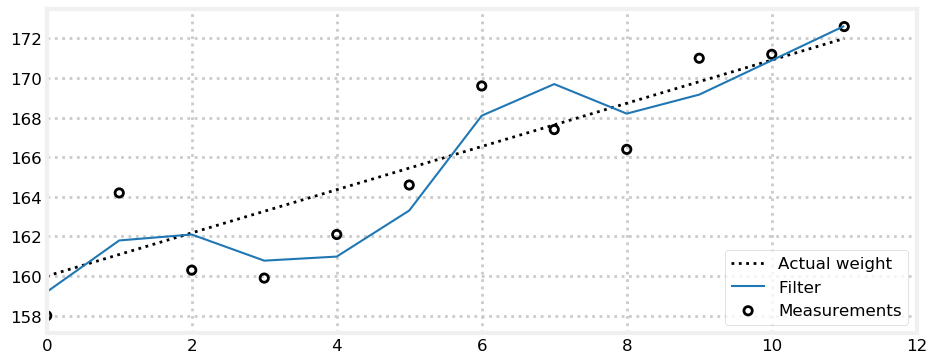

In [23]:
from kf_book.gh_internal import plot_g_h_results
import matplotlib.pylab as pylab

def g_h_filter(data, x0, dx, g, h, dt=1.):
    x_est = x0
    results = []
    for z in data:
        # prediction step
        x_pred = x_est + (dx*dt)
        dx = dx

        # update step
        residual = z - x_pred
        dx = dx + h * (residual) / dt
        x_est = x_pred + g * residual
        results.append(x_est)
    return np.array(results)

book_plots.plot_track([0, 11], [160, 172], label='Actual weight')
data = g_h_filter(data=weights, x0=160., dx=1., g=6./10, h=2./3, dt=1.)
plot_g_h_results(weights, data)

其实和之前的程序比起来，这段代码没有任何改变，只不过变量名字改的通用一点儿了。

##  $g$   $h$ 的选择

g-h滤波不是一个孤立的滤波器，而是一个统称。卡尔曼滤波就是g-h滤波的一种，并且还有很多其他滤波器。还不止于此，这些滤波器还有自己的变种。每种滤波器只是$g$和$h$的计算（选择）算法不一样。所以，对于这两个参数的选择没有一个放之四海而皆准的道理。有的滤波器将其设置为常数，有的则动态变化。例如卡尔曼滤波每一步都会进行参数的更新。有的滤波器允许这两个参数可以选择一定范围内的任意值。有的则是通过一个参数计算另一个参数，$f(\dot{}), \mbox{where }g = f(h)$.

本书不涵盖所有的g-h滤波， 我们关注的是一个叫*贝叶斯*的东西（暂时还没讲到）。所以我们不深入探讨$g$和$h$的选择，这方面*Tracking and Kalman Filtering Made Easy*是个不错的参考。其实卡尔曼滤波中根本没有用$g$和$h$。可卡尔曼滤波仍是一种g-h滤波，因为从数学本质上可以归结到此算法。当我们设计卡尔曼滤波器的时候，我们使用一个与$g$ $h$本质相同的设计准则，但卡尔曼滤波的思路更强大。可能现在有点晕，不过别担心，到我们设计卡尔曼滤波器的时候一切都会柳暗花明。

我们还是要意识到$g$ $h$的选取对结果影响巨大，所以我们还有继续看几个例子。这样我们可以直观感受到这类滤波器的强大与其固有缺陷，这也有利于我们理解高深的卡尔曼滤波。

## 练习: 写一个函数生成量测数据

现在我们来写一个函数生成带噪声的数据。本书中对于噪声数据的建模采用信号加[白噪声](https://en.wikipedia.org/wiki/White_noise)的策略.前边我们没有讲什么是白噪声。简单起见暂时这么想，白噪声是随机变化的一会儿高一会儿低的数据，并且没有任何规律可言。白噪声是零均值，有限方差的不相关的变量。如果你还是没懂，没关系，后边的*高斯分布*的章节会讲。如果你没有任何统计学的知识，可以直接看答案和探讨。


函数 `numpy.random.randn()`可产生白噪声.我们需要这个函数有以下功能，输入一个初始值、一个数据变化率、我们需要的数据数、噪声，输出量测值。这里我们创建30个点，然后用上边的`g_h_filter()`滤波进行处理，然后用`plot_g_h_results()`看一下结果.

In [23]:
# your code here

### 答案

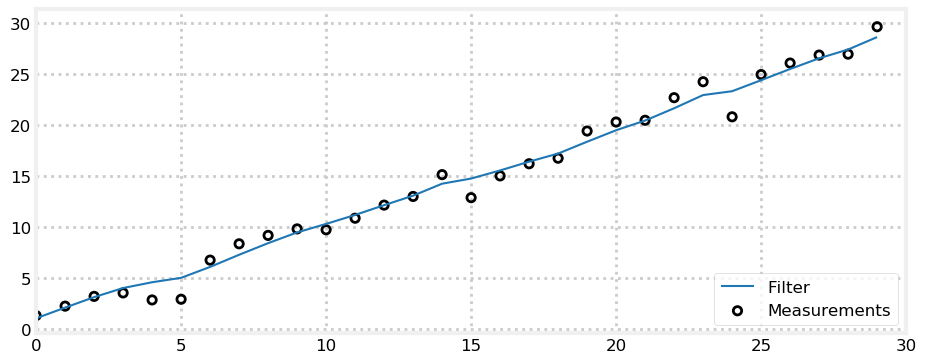

In [25]:
from numpy.random import randn
def gen_data(x0, dx, count, noise_factor):
    return [x0 + dx*i + randn()*noise_factor for i in range(count)]

measurements = gen_data(0, 1, 30, 1)
data = g_h_filter(data=measurements, x0=0., dx=1., dt=1., g=.2, h=0.02)
plot_g_h_results(measurements, data)

### 讨论

`randn()` 返回0均值随机数，即返回结果大于0和小于0的概率一样，波动范围可用标准差衡量，此函数生成数据的标准差为1。下边我用此函数生成了3000个点，可以看到生成的值基本都在-1到1之间，当然也有些跑出去了。

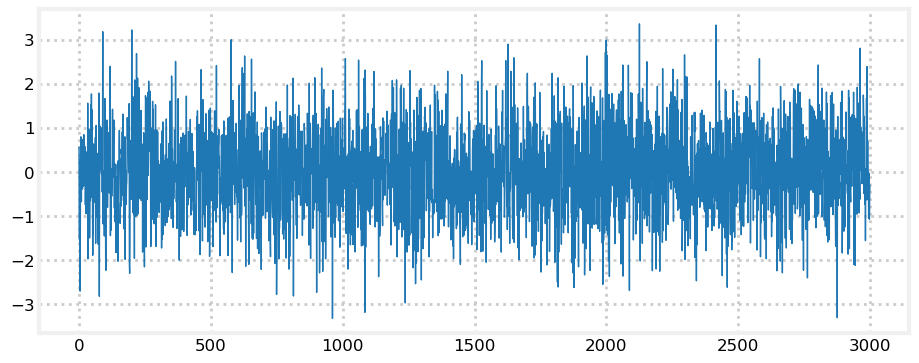

In [25]:
plt.plot([randn() for _ in range(3000)], lw=1);

## 练习: 糟糕初值的影响

现在我用 `gen_data`生成100个点，起点为5，变化率为2，噪声标准差为10，然后用 `g_h_filter`进行处理， g=0.2 and h=0.02. 我们把滤波初值设置为100.

In [26]:
# your code here

### 答案和探讨

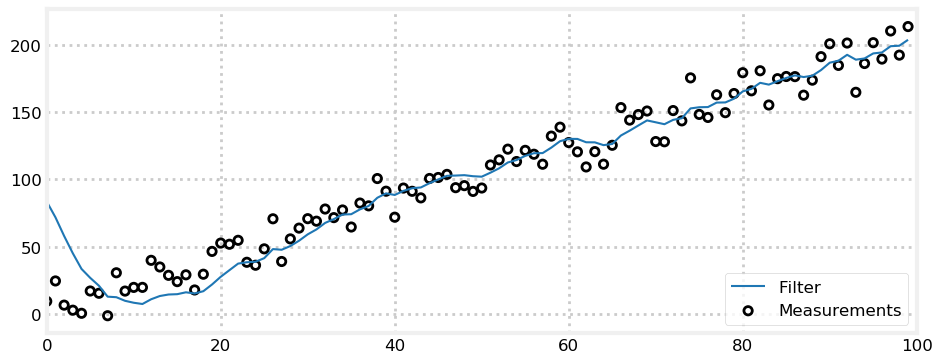

In [27]:
zs = gen_data(x0=5., dx=2., count=100, noise_factor=10)
data = g_h_filter(data=zs, x0=100., dx=2., dt=1., g=0.2, h=0.02)
plot_g_h_results(measurements=zs, filtered_data=data)

因为我们选择了一个很离谱的初值100，滤波器开始时输出的估计值和量测离得很远。可以看到在跟上量测数据之前，滤波输出有个超调，即滤波值往回收敛时穿过了量测趋势线，然后又被拉回来。这在滤波器中是个很常见的现象，有大量的研究来减小这个超调量。这里我们介绍这个现象，不做进一步研究。

## 练习: 大噪声

还是用这个例子，只不过我们把噪声的标准差增大到100.初值从100调回5.

In [28]:
# your code here

### 答案和讨论

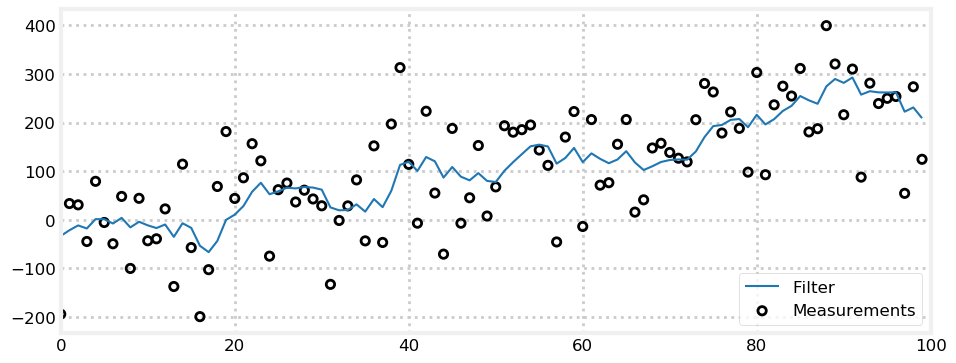

In [29]:
zs = gen_data(x0=5., dx=2., count=100, noise_factor=100)
data = g_h_filter(data=zs, x0=5., dx=2., g=0.2, h=0.02)
plot_g_h_results(measurements=zs, filtered_data=data)

结果看起来不理想。或许滤波结果比量测好很多，可是离直线差的远。如果我们只是把滤波结果给别人看，估计没人能看出这是一个初值为5，变化率为2的直线。有的地方滤波器明显的降低了噪声，可有的地方明显反应过头了，或者说被坏的量测带跑偏了。

不过目前我们不能断定这个滤波器不好，因为我们加的噪声有点太大了，或许这已经是滤波器的极限了。不过，本书的剩余章节会告我们，我们可以做的更好。

## 练习: 加速度的影响

修改一下量测生成函数。我们在生成数据的时候加入一个恒定的加速度。换句话说，每一个历元中，我们都将dx增加一个常数，这样数据的速度就是增长的。我们把噪声设置为0。使用 $g=0.2$   $h=0.02$ 进行一下滤波，看看会发生什么.

In [30]:
# your code here

### Solution and Discussion

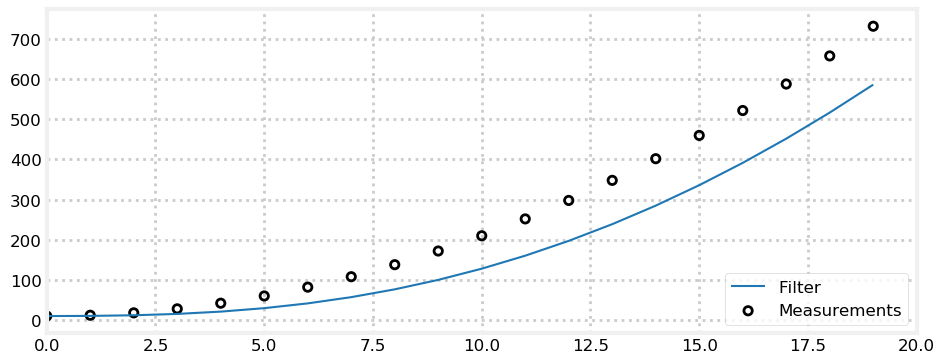

In [31]:
def gen_data(x0, dx, count, noise_factor, accel=0.):
    zs = []
    for i in range(count):
        zs.append(x0 + dx*i + randn()*noise_factor)
        dx += accel
    return zs
   
predictions = []
zs = gen_data(x0=10., dx=0., count=20, noise_factor=0, accel=2.)
data = g_h_filter(data=zs, x0=10., dx=0., g=0.2, h=0.02)
plt.xlim([0, 20])
plot_g_h_results(measurements=zs, filtered_data=data)

每一个滤波值都滞后于信号，其实这种结果是情理之中的。我们的模型是基于速度不变得。我们的模型中考虑了状态$x$的一阶微分$\dot{x}$ 但是没有考虑$\ddot{x}$。所以模型认为$\ddot{x}=0$。 在一步递推时，我们使用公式 $x=x + \dot{x}*t$。 但是由于加速度的存在，递推必然落后于真值。我们会计算新的速度$\dot{x}$,可是由于系数$h$的存在，我们只能对$\dot{x}$做有限的调节。所以，下一个历元我们仍然是滞后的。

这里没有$g$ 或 $h$的调节机制来改善这个问题。这个误差叫做*系统误差*，*模型误差*或者*滞后误差*.这是g-h滤波的一个属性。或许你脑中已经浮现出此问题的解决办法。或许你会期待，一定有好多这方面的研究了，作者会在本书中展示这些成果。

> 这里有一点我们要牢记于心，滤波器的效果是会受限于模型对真实世界的表达程度的。

## 练习: 变 $g$

现在我们看一下$g$的影响。开始之前回忆一下$g$是做什么的？$g$是调节量测和预测所占比重的比例系数。那么$g$很大或者很小对滤波器有什么影响呢？

现在我们生成一段量测，令 `noise_factor=50`  `dx=5`. 我们看一下 $g = 0.1\mbox{, } 0.4,\mbox{ 和 } 0.8$ 的滤波结果.

In [32]:
# your code here

### 答案与讨论

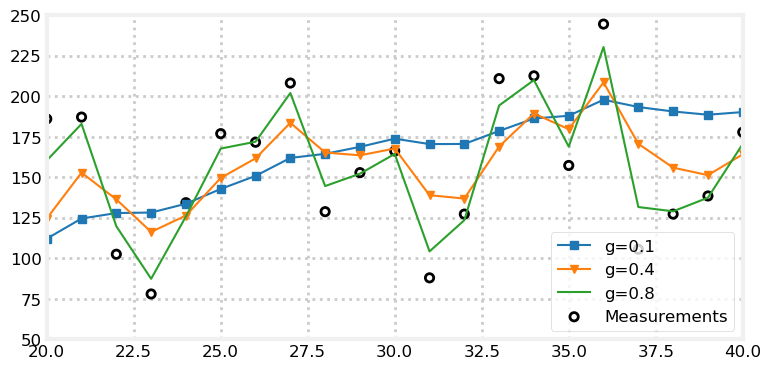

In [33]:
np.random.seed(100)
zs = gen_data(x0=5., dx=5., count=50, noise_factor=50)
data1 = g_h_filter(data=zs, x0=0., dx=5., dt=1., g=0.1, h=0.01)
data2 = g_h_filter(data=zs, x0=0., dx=5., dt=1., g=0.4, h=0.01)
data3 = g_h_filter(data=zs, x0=0., dx=5., dt=1., g=0.8, h=0.01)

with book_plots.figsize(y=4):
    book_plots.plot_measurements(zs, color='k')
    book_plots.plot_filter(data1, label='g=0.1', marker='s', c='C0')
    book_plots.plot_filter(data2, label='g=0.4', marker='v', c='C1')
    book_plots.plot_filter(data3, label='g=0.8', c='C2')
    plt.legend(loc=4)
    book_plots.set_limits([20, 40], [50, 250])

明显看出$g$越大，我们的结果越接近量测。当$g=0.8$时我们的滤波结果几乎等同于量测而没有任何噪声的消除作用了。看到此处有人可能会说了，那就要把$g$设小一点，这样去除噪声的效果就会很好。然而，若如此那意味着我们就把寄希望于预测而忽视了量测了。如果某个点的跳动是信号本身的变化引起的，而不是噪声呢？我们看一下这种情况，我们生成一段数据，开始时数据有一个$\dot{x}=1$ 的变化率，然后我们令$\dot{x}=0$。 

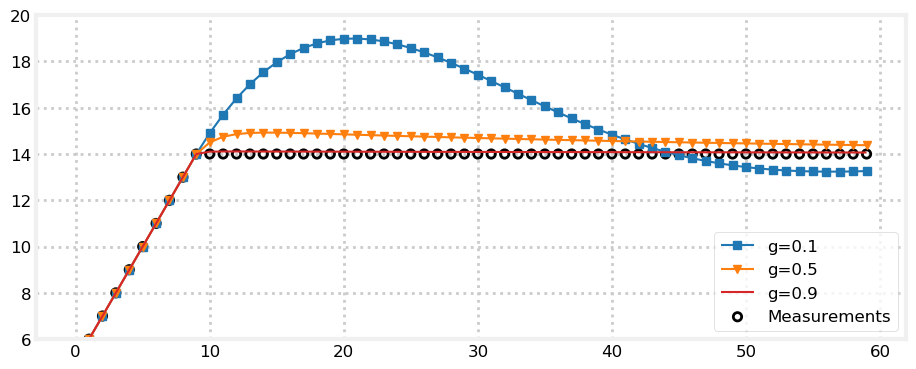

In [34]:
zs = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
for i in range(50):
    zs.append(14)

data1 = g_h_filter(data=zs, x0=4., dx=1., dt=1., g=0.1, h=0.01)
data2 = g_h_filter(data=zs, x0=4., dx=1., dt=1., g=0.5, h=0.01)
data3 = g_h_filter(data=zs, x0=4., dx=1., dt=1., g=0.9, h=0.01)

book_plots.plot_measurements(zs)
book_plots.plot_filter(data1, label='g=0.1', marker='s', c='C0')
book_plots.plot_filter(data2, label='g=0.5', marker='v', c='C1')
book_plots.plot_filter(data3, label='g=0.9', c='C3')
plt.legend(loc=4)
plt.ylim([6, 20]);

看到了吧。很小的g倒是把噪声滤掉了，不过信号的变化也无法跟上了。

或许我们需要一个类似“金发女孩原则”的滤波器，$g$既不大也不小。记得么？前边我们说过不同的滤波器使用不同的方法计算$g$   $h$。例如，Benedict-Bordner滤波器适用于本例中这种$\dot{x}$有突变的场景。本书中我们并不研究这种滤波器，但是我们可以看看这种滤波器的效果，见下图。当然为了消除这种$\dot{x}$突变引起的误差，此滤波器也做出了“牺牲”，那就是对$\dot{x}$其他类型的变化则深感不适。

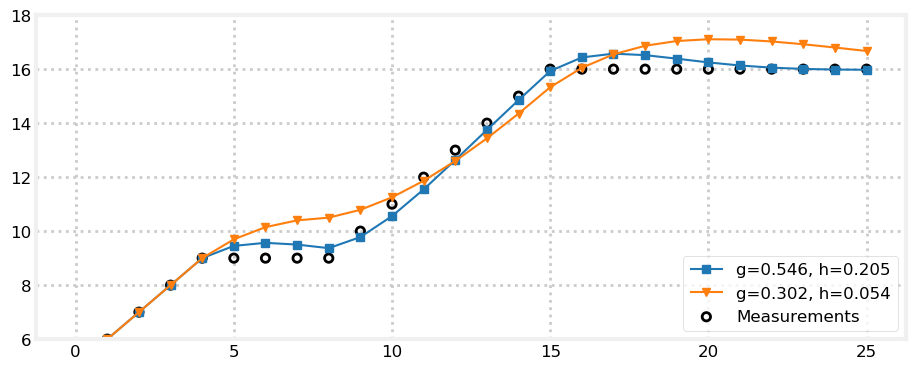

In [26]:
zs = [5,6,7,8,9,9,9,9,9,10,11,12,13,14,
      15,16,16,16,16,16,16,16,16,16,16,16]
data1 = g_h_filter(data=zs, x0=4., dx=1., dt=1., g=.302, h=.054)
data2 = g_h_filter(data=zs, x0=4., dx=1., dt=1., g=.546, h=.205)

book_plots.plot_measurements(zs)
book_plots.plot_filter(data2, label='g=0.546, h=0.205', marker='s', c='C0')
book_plots.plot_filter(data1, label='g=0.302, h=0.054', marker='v', c='C1')
plt.legend(loc=4)
plt.ylim([6, 18]);

## 练习： 变$h$

好了，我们这次固定$g$，来研究一下$h$变化的影响。$h$是对$\dot{x}$量测和预测的权衡因子。这意味着什么呢？如果我们的信号变化很快，那么大点的$h$可以快速的跟踪这种变化，而$h$较小时则不然。

我们来看个例子。我们生成一组0噪声量测，量测值经过50个历元，从0缓变到1.

- 第一个滤波器使用$\dot{x}$的真值作为初值，并且使用较小的$h$
- 第二个滤波在滤波器1的基础上设置$\dot{x}=2$
- 第三个滤波器在滤波器2的基础上设置$h=0.5$

可以看到滤波器1几乎等于真值，滤波器2有个很大的超调，滤波器3的超调从幅值上看比2小了很多，但是却震荡了多次。

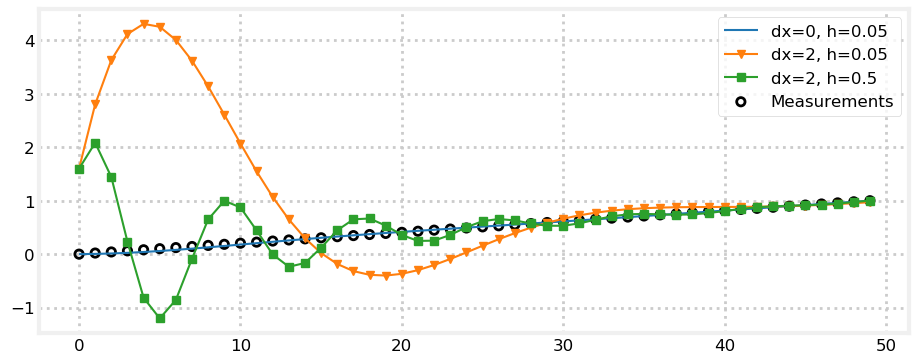

In [27]:
zs = np.linspace(0, 1, 50)

data1 = g_h_filter(data=zs, x0=0, dx=0., dt=1., g=.2, h=0.05)
data2 = g_h_filter(data=zs, x0=0, dx=2., dt=1., g=.2, h=0.05)
data3 = g_h_filter(data=zs, x0=0, dx=2., dt=1., g=.2, h=0.5)

book_plots.plot_measurements(zs)
book_plots.plot_filter(data1, label='dx=0, h=0.05', c='C0')
book_plots.plot_filter(data2, label='dx=2, h=0.05', marker='v', c='C1')
book_plots.plot_filter(data3, label='dx=2, h=0.5',  marker='s', c='C2')
plt.legend(loc=1);

## 互动

如果你正在用Jupyter Notebook阅读本书，那么恭喜你。因为你可以使用下边的交互程序来，直观的观看$\dot{x}$, $g$ 和 $h$对滤波器输出的影响。你可以通过滑动条来调节这三个值，然后图形会实时显示参数调节对结果的影响。

你也可以设想调节的效果，然后移动滑动条验证自己的想法。



Some things to try include setting $g$  and $h$ to their minimum values. See how perfectly the filter tracks the data! This is only because we are perfectly predicting the weight gain. Adjust $\dot{x}$ to larger or smaller than 5. The filter should diverge from the data and never reacquire it. Start adding back either $g$ or $h$ and see how the filter snaps back to the data. See what the difference in the line is when you add only $g$ vs only $h$. Can you explain the reason for the difference? Then try setting $g$ greater than 1. Can you explain the results? Put $g$ back to a reasonable value (such as 0.1), and then make $h$ very large. Can you explain these results? Finally, set both $g$ and $h$ to their largest values. 
 
If you want to explore with this more, change the value of the array `zs` to the values used in any of the charts above and rerun the cell to see the result.

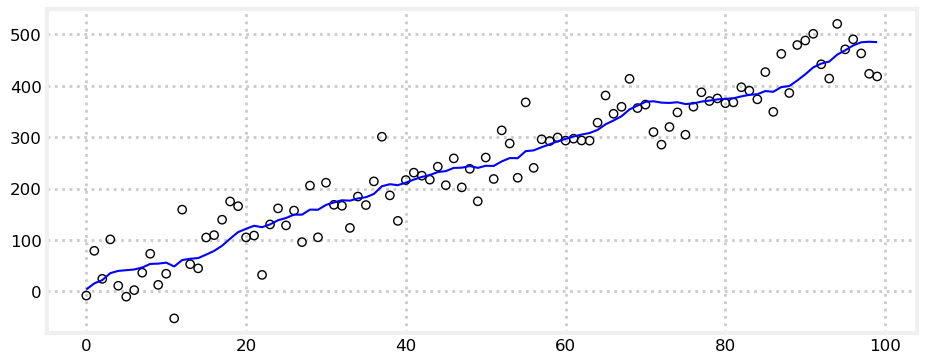

In [29]:
from ipywidgets import interact

# my FloatSlider returns an ipywidgets.FloatSlider with
# continuous_update=False. Filtering code runs too slowly
# to instantly react to slider changes.
from kf_book.book_plots import FloatSlider

zs1 = gen_data(x0=5, dx=5., count=100, noise_factor=50)

fig = None
def interactive_gh(x, dx, g, h):
    global fig
    if fig is not None: plt.close(fig)
    fig = plt.figure()
    data = g_h_filter(data=zs1, x0=x, dx=dx, g=g, h=h)
    plt.scatter(range(len(zs1)), zs1, edgecolor='k', 
                facecolors='none', marker='o', lw=1)
    plt.plot(data, color='b')

interact(interactive_gh,           
         x=FloatSlider(value=0, min=-200, max=200), 
         dx=FloatSlider(value=5, min=-50, max=50), 
         g=FloatSlider(value=.1, min=.01, max=2, step=.02), 
         h=FloatSlider(value=.02, min=.0, max=.5, step=.01));

## 别欺骗滤波器

你可以随心所欲的设置 $g$ 和 $h$. 下边的滤波器在极端噪声下表现完美。

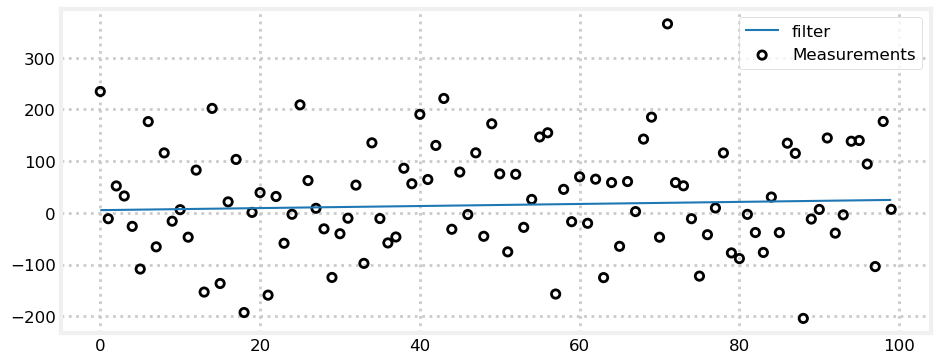

In [38]:
zs = gen_data(x0=5., dx=.2, count=100, noise_factor=100)
data = g_h_filter(data=zs, x0=5., dx=.2, dt=1., g=0., h=0.)

book_plots.plot_measurements(zs)
book_plots.plot_filter(data, label='filter')
plt.legend(loc=1);

上边的例子总将$g$ 和 $h$设置为0，我们可以在量测值中间画一条完美的直线。可这样有啥意义呢？将这两个参数设置为0意味着我们用公式$x + \Delta x \Delta t$进行滤波器的更新，而完全忽略了量测。结果当然是一条直线。

但是忽略量测的滤波器不是真正的滤波器（这是一个赌徒，把所有鸡蛋放在了预测这个篮子里）。我们不是赌徒，当然不会把这两个值设置为0，但是如果我们不够谨慎的话，很容易把这两个值设置的太小。通过把这两个值设的小一点，不难把一组测试数据滤的很漂亮。但是当你把调好的滤波器用来滤其他数据时，你傻眼了，因为你的参数是用一个特定的数据集调节出来的。$g$ 和 $h$是用来反应你所处理的系统的真实物理规律的，而不是为了迎合某一组数据。后边的章节我们我介绍，如何反应真实的物理规律。此处我只能说，别掉以轻心，否则你调好的滤波器上线时很可能是下边这个样子的:

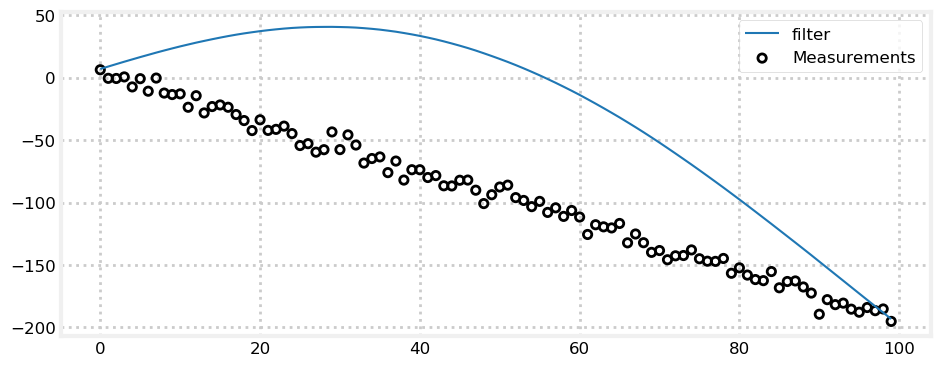

In [30]:
zs = gen_data(x0=5, dx=-2, count=100, noise_factor=5)
data = g_h_filter(data=zs, x0=5., dx=2., dt=1., g=.005, h=0.001)
book_plots.plot_measurements(zs)
book_plots.plot_filter(data, label='filter')
plt.legend(loc=1);

## 跟踪火车

万事俱备，我们结束思想实验，来到真实的世界。之前我们提到过跟踪火车的场景。火车这个庞然大物很难在速度上有突变发生。火车的运行受限于铁轨，所以也无法突然改变运行方向，只能慢慢停下，然后向另一个方向运行。因此我们可以设想，如果我们知道火车的一个概略坐标和速度，我们就可以比较准确的预测出火车下一个时刻的位置。

现在来写一个火车的滤波器。我们用火车离某个参考点的距离来表示火车的位置。所以如果我们说火车的位置是1，那么意味着火车离参考点1km远了，速度用m/s表示。 我们每秒进行一次量测，量测误差大约$\pm$ 500 meters.那么我们实现滤波器的步骤是？

首先，我们要仿真出还没有滤波器的情况。设想火车位置为23，速度15m/s，于是


```python
pos = 23*1000
vel = 15
```

假设火车速度不变，我们可以计算一段时间的火车位置，

```python
def compute_new_position(pos, vel, dt=1):
    return pos + (vel * dt)
```

基于计算的位置，我们加入随机噪声（之前我们假设误差是500m），这样量测值就出来了:

```python
def measure_position(pos):
        return pos + random.randn()*500
```
        
我们来生成100s的量测数据.

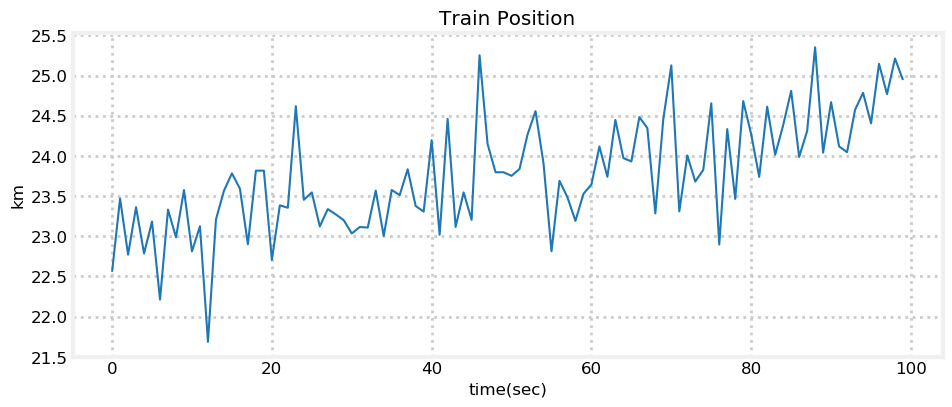

In [33]:
from numpy.random import randn

def compute_new_position(pos, vel, dt=1.):
    """ dt is the time delta in seconds."""
    return pos + (vel * dt)

def measure_position(pos):
    return pos + randn()*500

def gen_train_data(pos, vel, count):
    zs = []
    for t in range(count):
        pos = compute_new_position(pos, vel)
        zs.append(measure_position(pos))
    return np.asarray(zs)
  
pos, vel = 23.*1000, 15.
zs = gen_train_data(pos, vel, 100)

plt.plot(zs / 1000.)  # convert to km
book_plots.set_labels('Train Position', 'time(sec)', 'km')

由图可以看出，我们传感器输出的数据是很差的，真实世界中火车不可能这么运行。

那么我们怎么设置$g$和$h$呢？我们目前为止还没有介绍科学的方法，但是我们可以根据本章之前学到的东西来给出一个合理的解。既然量测精度很差，所以我们就减小量测的权重好了。就是说我们把$g$设小一点。火车的速度也不可能突变，因此$h$也小一点儿好了。那么：

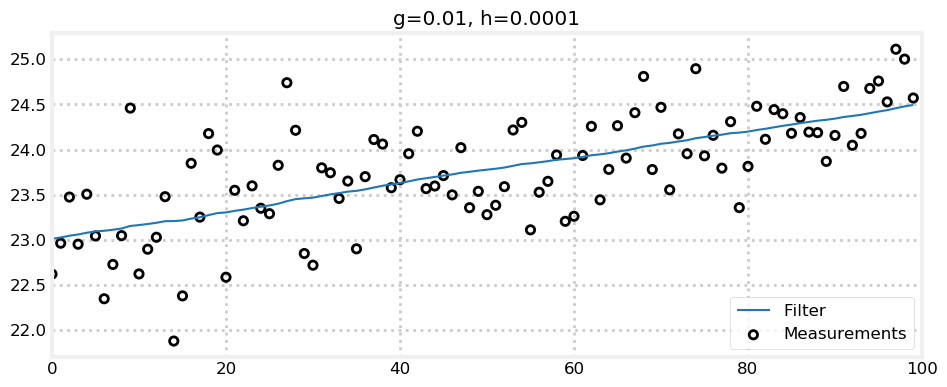

In [34]:
zs = gen_train_data(pos=pos, vel=15., count=100)
data = g_h_filter(data=zs, x0=pos, dx=15., dt=1., g=.01, h=0.0001)
plot_g_h_results(zs/1000., data/1000., 'g=0.01, h=0.0001')

完美！我们增大一下 $g$ 看看.

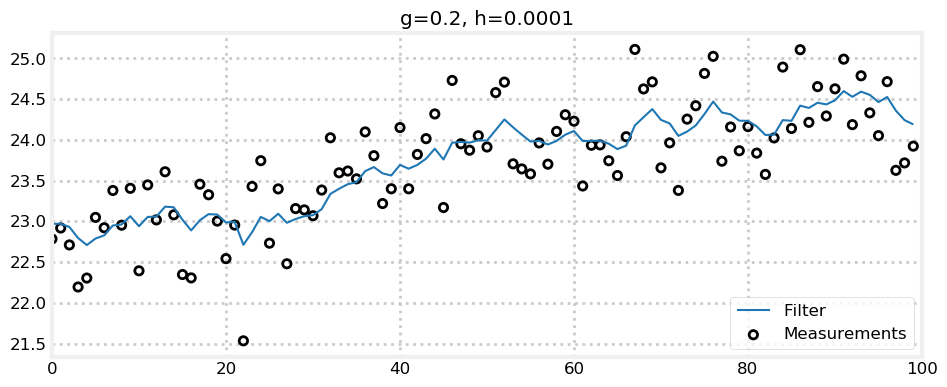

In [35]:
zs = gen_train_data(pos=pos, vel=15., count=100)
data = g_h_filter(data=zs, x0=pos, dx=15., dt=1., g=.2, h=0.0001)
plot_g_h_results(zs/1000., data/1000., 'g=0.2, h=0.0001')

从上图可以看出`g=0.2`的时候，火车的位置和速度已经出现波动了，看起来不大，但是真实世界中火车还是不会这么运动的。因此，从经验上讲，我们要使得`g<<0.2`

再来选 $h$.

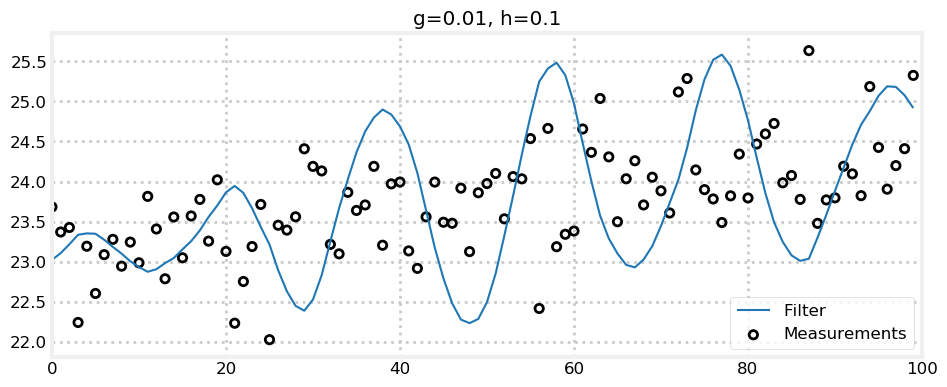

In [36]:
zs = gen_train_data(pos=pos, vel=15., count=100)
data = g_h_filter(data=zs, x0=pos, dx=15., dt=1., g=0.01, h=0.1)
plot_g_h_results(zs/1000., data/1000., 'g=0.01, h=0.1')

由于取了一个小$g$曲线很光滑了。可是拜$h$所赐，滤波结果对量测很敏感。因为几秒钟的时间量测巨大的误差，使得量测信息中隐含的变化率很大，如果我们把$h$设置的很大，那就是让滤波器包容这些变化信息。真实的火车速度不会这么蹦蹦跳跳，因此滤波器不会表现良好。

最后，我们来给火车加点加速度。我不知道火车加速度是多少，假设 0.2 m/sec^2吧. 

In [37]:
def gen_train_data_with_acc(pos, vel, count):
    zs = []
    for t in range(count):
        pos = compute_new_position(pos, vel)
        vel += 0.2
        zs.append(measure_position(pos))
    return np.asarray(zs) 

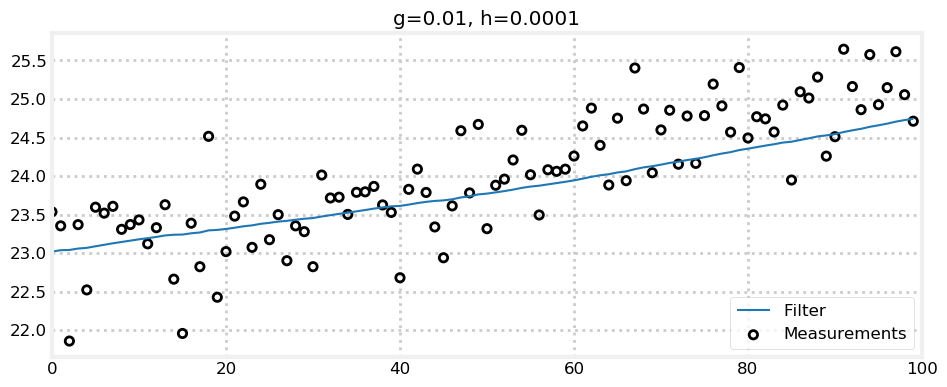

In [38]:
zs = gen_train_data_with_acc(pos=pos, vel=15., count=100)
data = g_h_filter(data=zs, x0=pos, dx=15., dt=1., g=.01, h=0.0001)
plot_g_h_results(zs/1000., data/1000., 'g=0.01, h=0.0001')

可以看到，由于引进了加速度，滤波器不能很好的跟踪火车了。我们可以让$h$大一点来提高跟踪性能，当然这会牺牲滤波结果的光滑性。

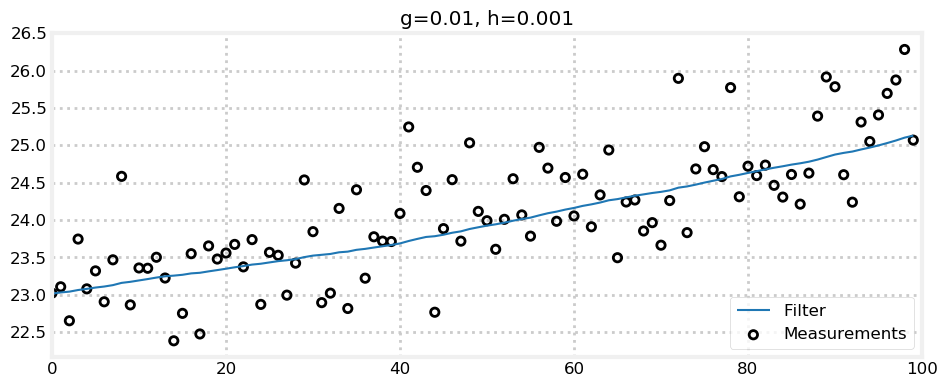

In [46]:
zs = gen_train_data_with_acc(pos=pos, vel=15., count=100)
data = g_h_filter(data=zs, x0=pos, dx=15., dt=1., g=.01, h=0.001)
plot_g_h_results(zs/1000., data/1000., 'g=0.01, h=0.001')

There are two lessons to be learned here. First, use the $h$ term to respond to changes in velocity that you are not modeling. But, far more importantly, there is a trade off here between responding quickly and accurately to changes in behavior and producing ideal output for when the system is in a steady state that you have. If the train never changes velocity we would make $h$ extremely small to avoid having the filtered estimate unduly affected by the noise in the measurement. But in an interesting problem there are almost always changes in state, and we want to react to them quickly. The more quickly we react to them, the more we are affected by the noise in the sensors. 

I could go on, but my aim is not to develop g-h filter theory here so much as to build insight into how combining measurements and predictions leads to a filtered solution. There is extensive literature on choosing $g$ and $h$ for problems such as this, and there are optimal ways of choosing them to achieve various goals. As I explained earlier it is easy to 'lie' to the filter when experimenting with test data like this. In the subsequent chapters we will learn how the Kalman filter solves this problem in the same basic manner, but with far more sophisticated mathematics. 

## g-h Filters with FilterPy

[FilterPy](https://github.com/rlabbe/filterpy) is an open source filtering library that I wrote. It has all of the filters in this book, along with others. It is rather easy to program your own g-h filter, but as we progress we will rely on FilterPy more. As a quick introduction, let's look at the g-h filter in FilterPy.

If you do not have FilterPy installed just issue the following command from the command line.

    pip install filterpy
    
Read Appendix A for more information on installing or downloading FilterPy from GitHub.

To use the g-h filter import it and create an object from the class `GHFilter`. 

In [47]:
from filterpy.gh import GHFilter
f = GHFilter(x=0., dx=0., dt=1., g=.8, h=.2)

When you construct the object you specify the initial value and rate of change for the signal (`x` and 'dx'), the time step between updates(`dt`) and the two filter parameter (`g` and `h`). `dx` must have the same units of `x`/`dt` - if `x` is in meters and `dt` is in seconds then `dx` must be in meters per second.

To run the filter call update, passing the measurement in the parameter `z`, which you'll recall is a standard name for measurements in the literature.

In [48]:
f.update(z=1.2)

(0.96, 0.24)

`update()` returns the new value of `x` and `dx` in a tuple, but you can also access them from the object.

In [49]:
print(f.x, f.dx)

0.96 0.24


You can dynamically alter `g` and `h`.

In [50]:
print(f.update(z=2.1, g=.85, h=.15))

(1.965, 0.375)


You can filter a sequence of measurements in a batch.

In [51]:
print(f.batch_filter([3., 4., 5.]))

[[1.965 0.375]
 [2.868 0.507]
 [3.875 0.632]
 [4.901 0.731]]


You can filter multiple independent variables. If you are tracking an aircraft you'll need to track it in 3D space. Use NumPy arrays for `x`, `dx`, and the measurements.

In [52]:
x_0  = np.array([1., 10., 100.])
dx_0 = np.array([10., 12., .2])
               
f_air = GHFilter(x=x_0, dx=dx_0, dt=1., g=.8, h=.2)
f_air.update(z=np.array((2., 11., 102.)))
print(' x =', f_air.x)
print('dx =', f_air.dx)

 x = [  3.8   13.2  101.64]
dx = [8.2  9.8  0.56]


The class `GHFilterOrder` allows you to create a filter of order 0, 1, or 2. A g-h filter is order 1. The g-h-k filter, which we haven't talked about, also tracks accelerations. Both classes have functionality required by real applications, such as computing the Variance Reduction Factor (VRF), which we haven't discussed in this chapter. I could fill a book just on the theory and applications of g-h filters, but we have other goals in this book. If you are interested, explore the FilterPy code and do some further reading.

The documentation for FilterPy is at https://filterpy.readthedocs.org/.

## Summary

I encourage you to experiment with this filter to develop your understanding of how it reacts. It shouldn't take too many attempts to come to the realization that ad-hoc choices for $g$ and $h$ do not perform very well. A particular choice might perform well in one situation, but very poorly in another. Even when you understand the effect of $g$ and $h$ it can be difficult to choose proper values. In fact, it is extremely unlikely that you will choose values for $g$ and $h$ that is optimal for any given problem. Filters are *designed*, not selected *ad hoc*. 

In some ways I do not want to end the chapter here, as there is a significant amount that we can say about selecting $g$ and $h$. But the g-h filter in this form is not the purpose of this book. Designing the Kalman filter requires you to specify a number of parameters - indirectly they do relate to choosing $g$ and $h$, but you will never refer to them directly when designing Kalman filters. Furthermore, $g$ and $h$ will vary at every time step in a very non-obvious manner. 

There is another feature of these filters we have barely touched upon - Bayesian statistics. You will note that the term 'Bayesian' is in the title of this book; this is not a coincidence! For the time being we will leave $g$ and $h$ behind, largely unexplored, and develop a very powerful form of probabilistic reasoning about filtering. Yet suddenly this same g-h filter algorithm will appear, this time with a formal mathematical edifice that allows us to create filters from multiple sensors, to accurately estimate the amount of error in our solution, and to control robots.